The following question is implemented using the following [tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=FsePPpwZSmqt) 

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 4.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=43552021ad434fb23b80c6c523ab23b0f0a05900acd3fdd6fe739128ba238188
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 45.4 MB/s 
     |████████████████████████████████| 49 kB 2.3 MB/s 
     |████████████████████████████████| 130 kB 7.4 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 145 kB 50.1 MB/s 
     |████████████████████████████████| 843 kB 20.1 MB/s 
     |███████████████████████████████

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# Import libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [179]:
from google.colab import drive
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import glob
drive.mount('/content/drive')
import pandas as pd

cfg = get_cfg()
# Run Pre-Trained model
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 # Threshold for score to only keep higher confidence score
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5 # threshold such that IOU >= Threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Read Validation Traffic Image
im_list = []
csv_path = '/content/drive/My Drive/University/ECSE-415/ECSE_415_F_2021_Project/vehiclecounting/valid_count.csv'
path = '/content/drive/My Drive/University/ECSE-415/ECSE_415_F_2021_Project/vehiclecounting/TRANCOS/TRANCOS/'

# read csv file
df = pd.read_csv(csv_path)
expected_counts = list(df['counts'])
images = list(df['images'])

for image in images:
    im = mpimg.imread(path + str(image), 0)
    im_list.append(im)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
def detection (im_list, predictor):
  val_boxes = []
  for im in im_list:
    outputs = predictor(im)
    boxes = get_boxes(outputs)
    val_boxes.append(boxes)
  return val_boxes

In [37]:
# Extract boxes coordinates to draw boxes
def get_boxes(outputs):
  output_pred_boxes = outputs["instances"].pred_boxes
  box_coord = []
  for i in output_pred_boxes.__iter__():
    box_coord.append(tuple(i.cpu().numpy()))
  return box_coord

## Display Image Example

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


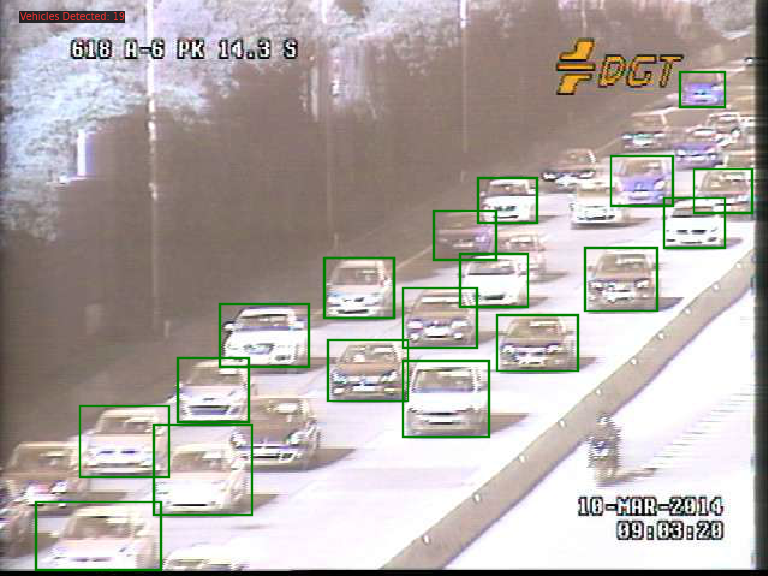

In [181]:
# Draw the predictions on the first image.
v = Visualizer(im_list[0][:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# Get list of boxes for every images
boxes_coord = detection(im_list, predictor)

# Draw boxes on first image
for coord in boxes_coord[0]:
  out = v.draw_box(coord, alpha = 1)
# Write count of vehicles detected
v.draw_text('Vehicles Detected: ' + str(len(boxes_coord[0])), (60,10), color = 'r')
cv2_imshow(out.get_image()[:, :, ::-1])

##Accuracy Evaluation

In [182]:
# Compute MDE Metric
def MDE (boxes_coord, expected_counts):
  mean_ac = []
  true_vehicle_counts = len(boxes_coord)
  for i in range(true_vehicle_counts):
    accuracy = (len(boxes_coord[i])/expected_counts[i])*100
    ac = np.append(mean_ac, accuracy)
  # Compute mean of results
  return np.mean(ac)
print('Mean Deviation Error: ' + str(MDE(boxes_coord, expected_counts))+ ' %')

Mean Deviation Error: 70.37037037037037 %


Display the scatter plot of true vehicle count (X-axis) vs the Predicted Vehicle Count (Y-Axis). R

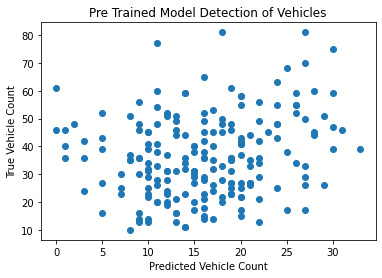

In [183]:
import matplotlib.pyplot as plt
true_vehicle_counts = len(boxes_coord)
x = []
for i in range(true_vehicle_counts):
  # Num box for each image
  n_box_img = len(boxes_coord[i])
  x = np.append(x, n_box_img)
fig, ax = plt.subplots()
ax.scatter(x, expected_counts)
ax.set_xlabel('Predicted Vehicle Count')
ax.set_ylabel('True Vehicle Count')
ax.set_title('Pre Trained Model Detection of Vehicles')
plt.show()

Pearson correlation coefficient and p-value for testing non-correlation.


The Pearson correlation coefficient measures the linear relationship between two datasets.

In [184]:
from scipy import stats
r, p = stats.pearsonr(x, expected_counts)
print('Pearson’s Correlation Coefficient: ' + str(r))

Pearson’s Correlation Coefficient: 0.1966423979603375


[Mean Absolute Error](https://www.dataquest.io/blog/understanding-regression-error-metrics/)

In [185]:
mae_sum = 0
mae_sum = np.sum(abs(x - expected_counts))
mae = mae_sum / len(expected_counts)
print('Mean Absolute Error: ' + str(mae))

Mean Absolute Error: 20.8


[Mean Square Error](https://https://www.dataquest.io/blog/understanding-regression-error-metrics/)

In [186]:
mse_sum = 0
mse_sum = np.sum((x - expected_counts)**2)
mse = mse_sum / len(expected_counts)

print('Mean Square Error: ' + str(mse))

Mean Square Error: 633.42
